In [57]:
#imports
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
import sys
import os




In [110]:
# --- User toggle ---
Cristina = True
Shar = not Cristina 

# --- System Configurations ---

if Cristina:
    print("[CONFIG] Using Cristina's local MacBook setup")
    sys.path.insert(0, "/Users/andradenebula/Documents/Research/Transient_Metrics/Multi_Transient_Metrics_Hub")
    os.environ["RUBIN_SIM_DATA_DIR"] = "/Users/andradenebula/rubin_sim_data"
    db_dir = "/Users/andradenebula/Documents/Research/Transient_Metrics/Multi_Transient_Metrics_Hub"

elif Shar:
    print("[CONFIG] Using Shar's Dirac server setup")
    sys.path.insert(0, "/lustre/lrspec/metrics")
    sys.path.insert(0, "/home/3155/metrics/Multi_Transient_Metrics_Hub")
    os.environ["RUBIN_SIM_DATA_DIR"] = "/lustre/lrspec/metrics/rubin_sim_data"
    db_dir = "/lustre/lrspec/metrics"

# Shared config
sys.path.append(os.path.abspath(".."))  # For shared_utils


[CONFIG] Using Cristina's local MacBook setup


In [112]:
#this happens twice because idk why but it only works like that
#...you still have to run it twice if it gives warnings
# C: Make sure you save your metric file before running. 

metric_filename = "new_names_local_GRBafterglows_metric"
s_u = "shared_utils"

# --- Reload metric module ---
if metric_filename in sys.modules:
    del sys.modules[metric_filename]
metric = __import__(metric_filename)
importlib.reload(metric)

# --- Reload shared_utils module ---
if s_u in sys.modules:
    del sys.modules[s_u]
shared_utils = __import__(s_u)
importlib.reload(shared_utils)

print(f"[INFO] Loaded metric module: {metric_filename}")
print(f"[INFO] Loaded shared_utils module")




/opt/anaconda3/envs/rubin_sim_223/lib/python3.11/site-packages/rubin_sim/maf/metrics/base_metric.py:32: UserWarning: Redefining metric new_names_local_GRBafterglows_metric.Base_Metric! (there are >1 metrics with the same name)
  warnings.warn("Redefining metric %s! (there are >1 metrics with the same name)" % (metricname))
/opt/anaconda3/envs/rubin_sim_223/lib/python3.11/site-packages/rubin_sim/maf/metrics/base_metric.py:32: UserWarning: Redefining metric new_names_local_GRBafterglows_metric.Detect_Metric! (there are >1 metrics with the same name)
  warnings.warn("Redefining metric %s! (there are >1 metrics with the same name)" % (metricname))
/opt/anaconda3/envs/rubin_sim_223/lib/python3.11/site-packages/rubin_sim/maf/metrics/base_metric.py:32: UserWarning: Redefining metric new_names_local_GRBafterglows_metric.GRBAfterglowBetterDetectMetric! (there are >1 metrics with the same name)
  warnings.warn("Redefining metric %s! (there are >1 metrics with the same name)" % (metricname))
/opt

[INFO] Loaded metric module: new_names_local_GRBafterglows_metric
[INFO] Loaded shared_utils module


In [114]:
#metric configurations

#control whether we generate new files
generate_new_templates = True
generate_new_pop = True
make_debug_plots = False #toggle whether or not the pop generation makes plots

#population variables
rate_density = 1e-8
dmin, dmax = 10, 1000
gal_lat_cut = None #latitude cut, for Galactic phenomena
t_start = 1 #start time in days
t_end = 3652

# Whether to remove Metric_temp_* folders after running
clean_temp = True  # <- NEW toggle

#cadence variables
cadences = ['four_roll_v4.3.1_10yrs', 'baseline_v4.3.1_10yrs']
ignore_triples = False #turn this to true to ignore triples
filters = ['u', 'g', 'r', 'i', 'z', 'y'] #doesn't work rn i think but
#if we wanted to look at less filters then we would adjust that here

# Standardized output paths for this science case
paths = metric.get_output_paths(case_label="GRBafterglows")  # <- can change to 'KNe' etc.

storage_dir = paths['storage_dir']
templates_file = paths['templates_file']
pop_file = paths['pop_file']


In [116]:
#load and/or generate light curves
shared_lc_model = metric.load_or_generate_templates(
    templates_file=templates_file,
    generate_new=generate_new_templates
)

[INFO] Generating 1000 light curve templates.
Saved synthetic GRB light curve templates to /Users/andradenebula/Documents/Research/Transient_Metrics/Multi_Transient_Metrics_Hub/output/GRBafterglows/GRBafterglows_templates.pkl
Loaded GRB afterglow templates from /Users/andradenebula/Documents/Research/Transient_Metrics/Multi_Transient_Metrics_Hub/output/GRBafterglows/GRBafterglows_templates.pkl


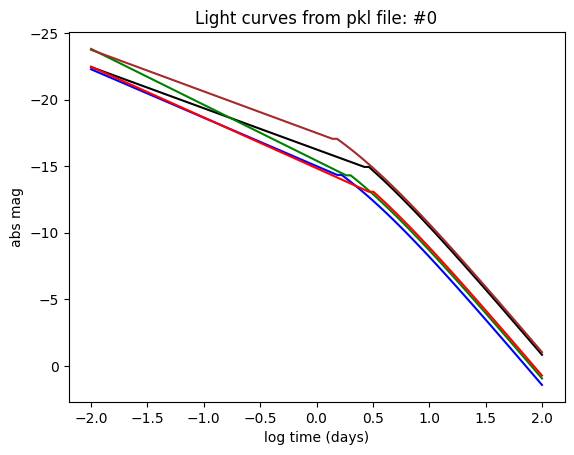

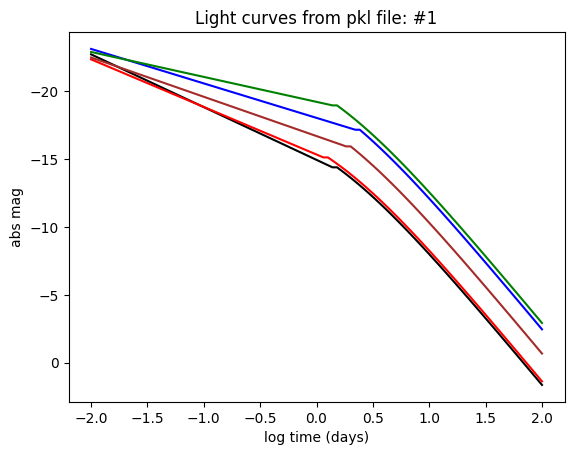

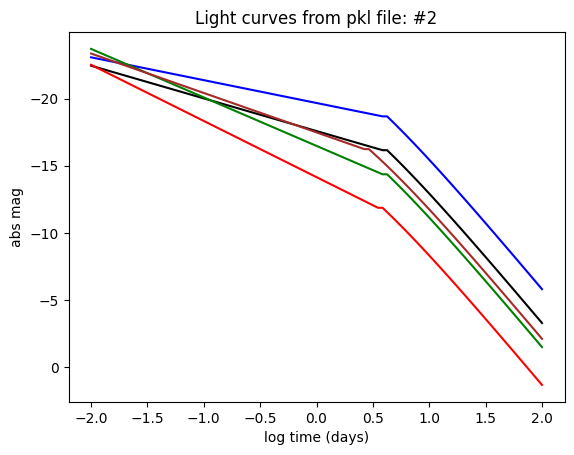

In [117]:
#plot light curves from pkl file if desired
shared_utils.plot_some_lcs_from_pkl(templates_file, num=3)

In [120]:
# Load or generate population slicer
slicer = metric.load_or_generate_population(
    t_start=t_start,
    t_end=t_end,
    d_min=dmin,
    d_max=dmax,
    seed=42,
    num_lightcurves=1000,
    gal_lat_cut=gal_lat_cut,
    rate_density=rate_density,
    pop_file=pop_file,
    generate_new=generate_new_pop,
    make_debug_plots=make_debug_plots
)


[INFO] Generating GRB population and saving to /Users/andradenebula/Documents/Research/Transient_Metrics/Multi_Transient_Metrics_Hub/output/GRBafterglows/GRBafterglows_population.pkl
Simulated 419 GRB events using rate_density = 1.0e-08
Saved GRB population to /Users/andradenebula/Documents/Research/Transient_Metrics/Multi_Transient_Metrics_Hub/output/GRBafterglows/GRBafterglows_population.pkl


## All 10 years


--- Running four_roll_v4.3.1_10yrs ---

Inspecting one obs_record before saving to CSV:
mjd_obs         | type: <class 'numpy.ndarray'> | length: 754
mag_obs         | type: <class 'numpy.ndarray'> | length: 754
snr_obs         | type: <class 'numpy.ndarray'> | length: 754
filter          | type: <class 'numpy.ndarray'> | length: 754
first_det_mjd   | type: <class 'float'> | value: nan
last_det_mjd    | type: <class 'float'> | value: nan
fade_time_days  | type: <class 'float'> | value: nan
sid             | type: <class 'numpy.int64'> | value: 1
file_indx       | type: <class 'numpy.int64'> | value: 419
ra              | type: <class 'numpy.float64'> | value: 0.6135923151542564
dec             | type: <class 'numpy.float64'> | value: -0.5848608108840141
distance_Mpc    | type: <class 'numpy.float64'> | value: 444.4896553545318
peak_mjd        | type: <class 'numpy.float64'> | value: 62323.386917571996
peak_mag        | type: <class 'numpy.float64'> | value: 31.276543354114022
ebv     

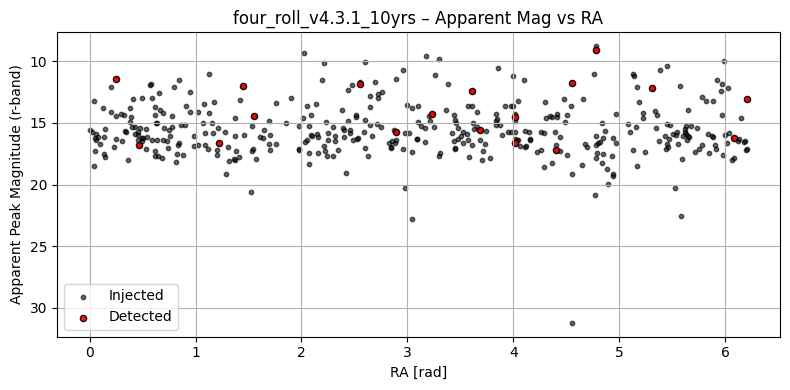

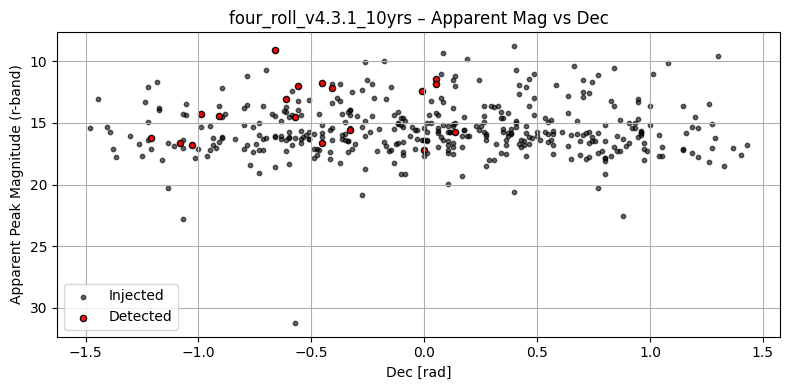

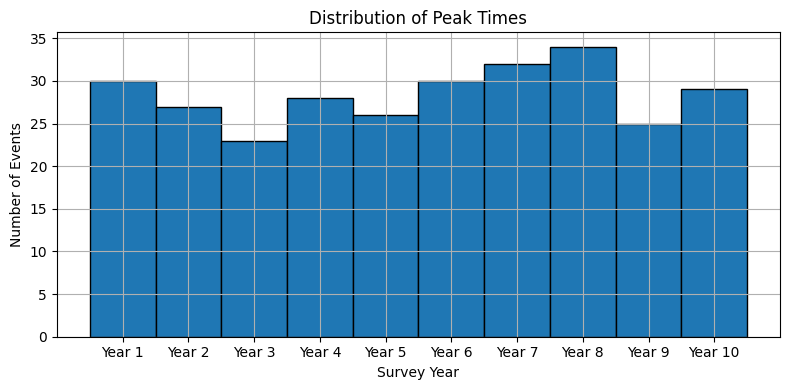

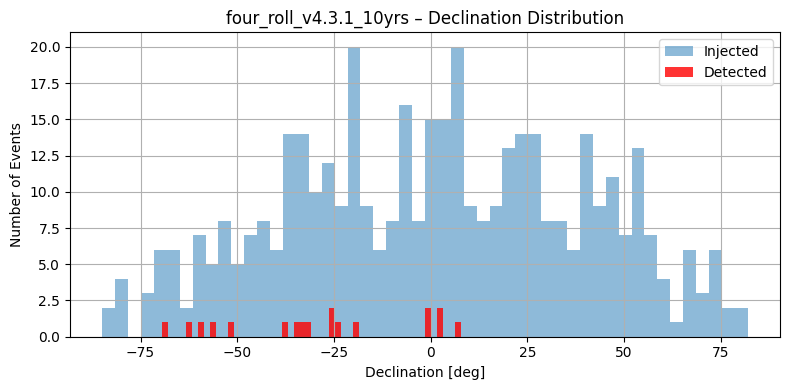


--- Running baseline_v4.3.1_10yrs ---

Inspecting one obs_record before saving to CSV:
mjd_obs         | type: <class 'numpy.ndarray'> | length: 778
mag_obs         | type: <class 'numpy.ndarray'> | length: 778
snr_obs         | type: <class 'numpy.ndarray'> | length: 778
filter          | type: <class 'numpy.ndarray'> | length: 778
first_det_mjd   | type: <class 'float'> | value: nan
last_det_mjd    | type: <class 'float'> | value: nan
fade_time_days  | type: <class 'float'> | value: nan
sid             | type: <class 'numpy.int64'> | value: 1
file_indx       | type: <class 'numpy.int64'> | value: 419
ra              | type: <class 'numpy.float64'> | value: 0.6135923151542564
dec             | type: <class 'numpy.float64'> | value: -0.5848608108840141
distance_Mpc    | type: <class 'numpy.float64'> | value: 444.4896553545318
peak_mjd        | type: <class 'numpy.float64'> | value: 63906.25227580979
peak_mag        | type: <class 'numpy.float64'> | value: 137.26697788398565
ebv       

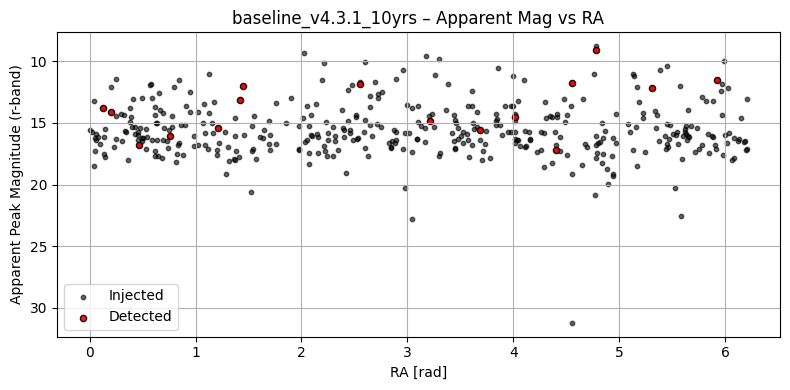

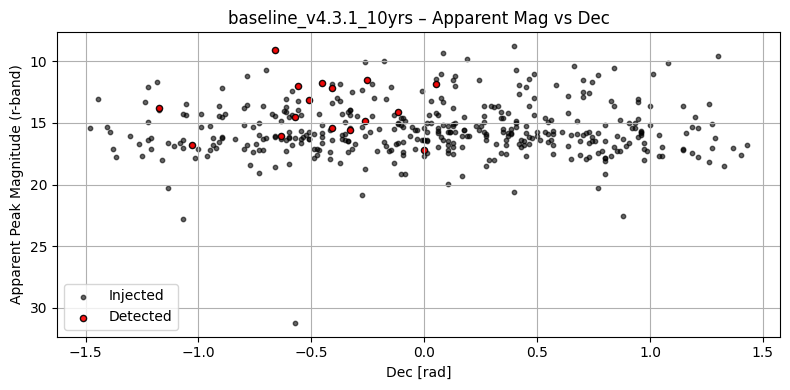

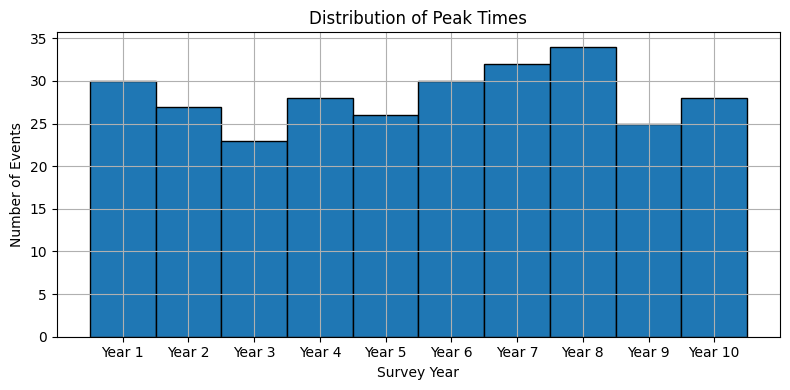

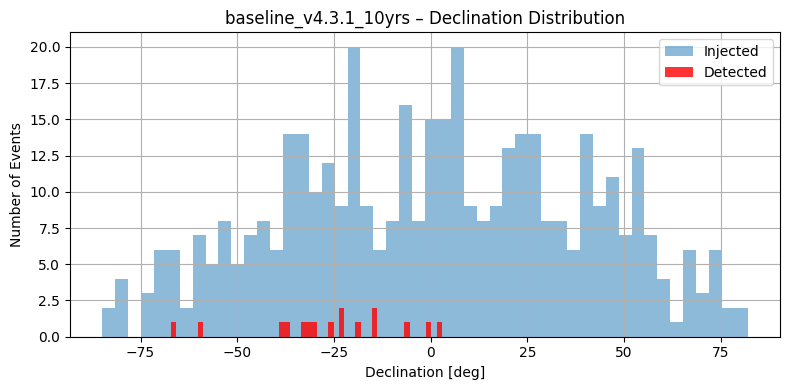

In [123]:
#run detection metric
df_obs_arr = shared_utils.run_detect(metric, slicer, cadences, shared_lc_model, db_dir, storage_dir, debug=True, plot=True, clean_temp=clean_temp)

In [126]:
#choose what to run in run_multi_metrics
# we can remove historical if we want
multi_metrics = metric.get_multi_metrics(shared_lc_model, include=['detect', 'characterize', 'spec_trigger'])



--- Running four_roll_v4.3.1_10yrs ---


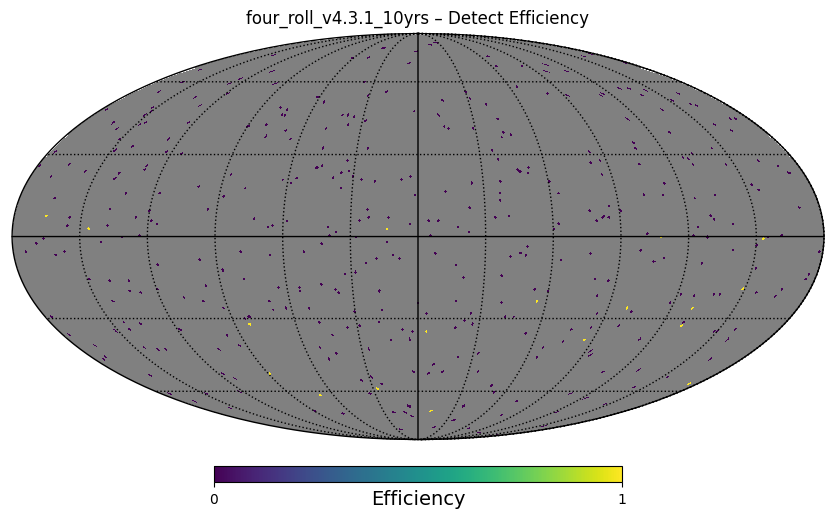

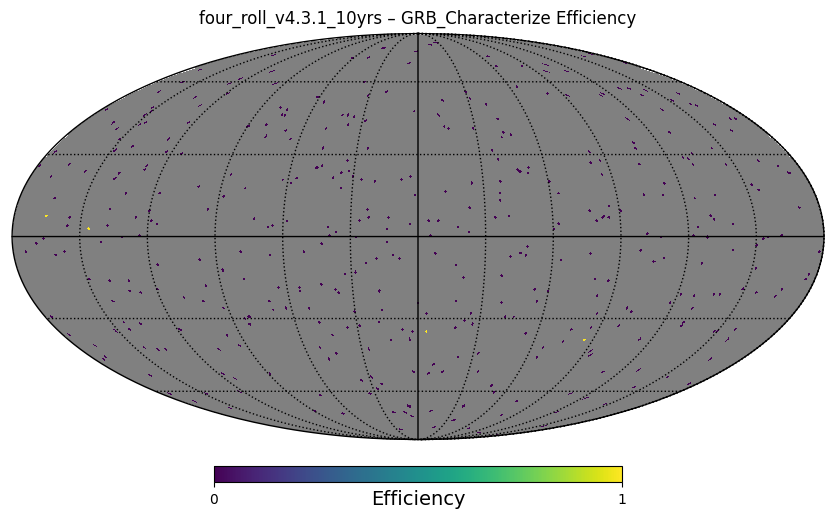

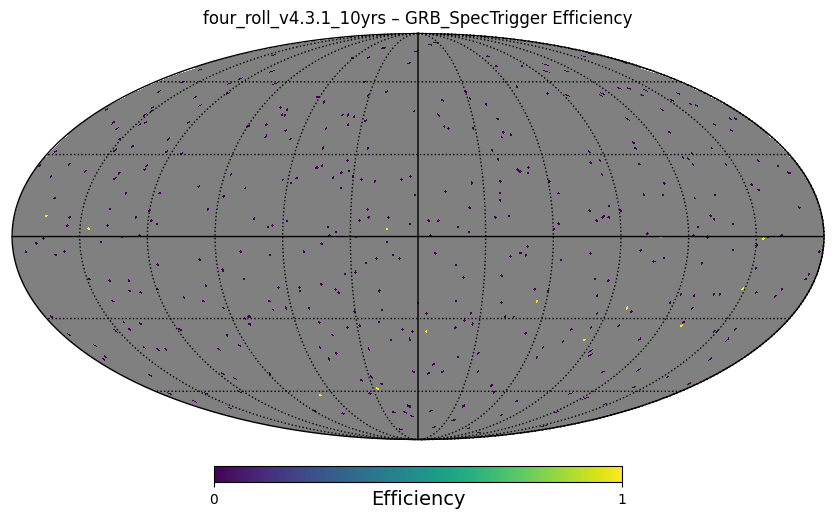

[CLEANUP] Removing temp directory: /Users/andradenebula/Documents/Research/Transient_Metrics/Multi_Transient_Metrics_Hub/output/GRBafterglows/Metric_temp_four_roll_v4.3.1_10yrs
[CLEANUP] Removing temp directory: /Users/andradenebula/Documents/Research/Transient_Metrics/Multi_Transient_Metrics_Hub/output/GRBafterglows/Metric_temp_baseline_v4.3.1_10yrs

--- Running baseline_v4.3.1_10yrs ---


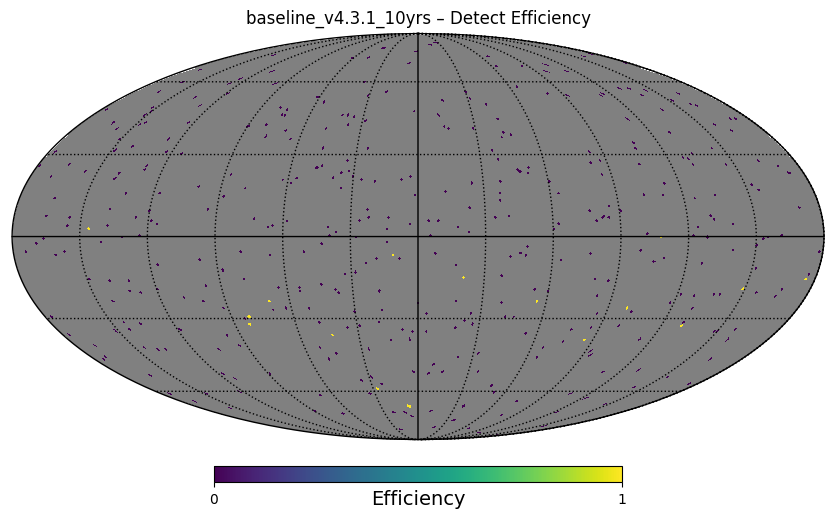

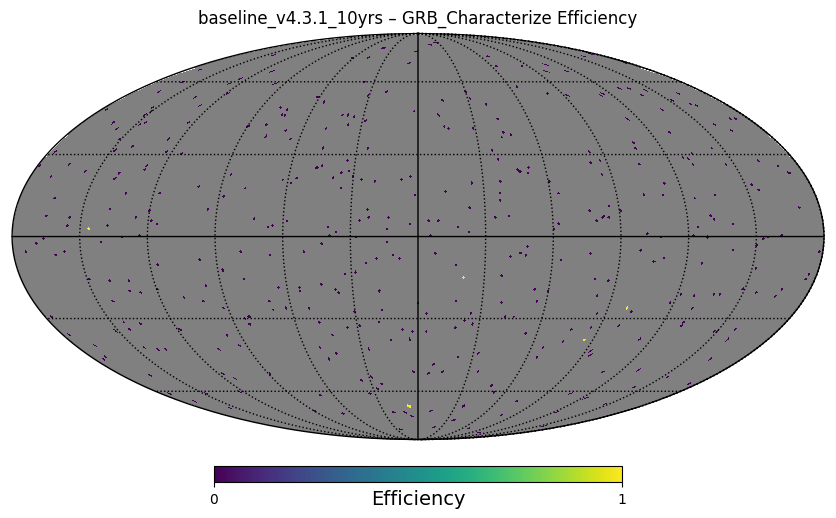

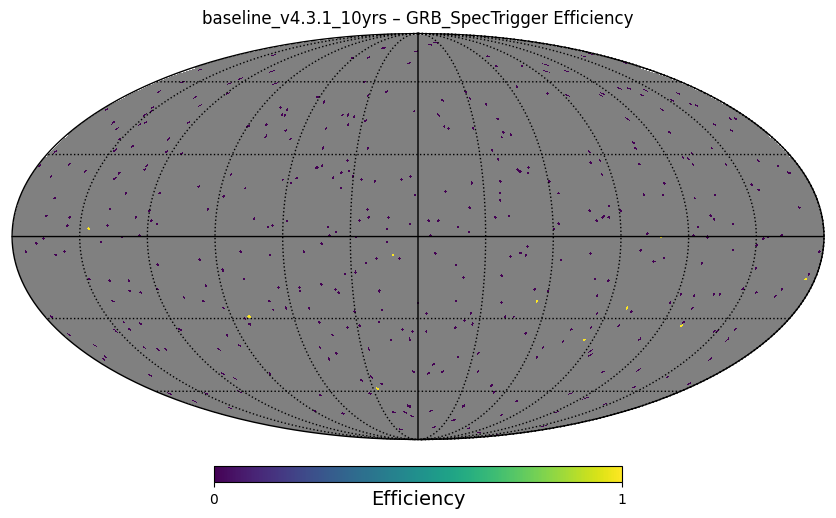

[CLEANUP] Removing temp directory: /Users/andradenebula/Documents/Research/Transient_Metrics/Multi_Transient_Metrics_Hub/output/GRBafterglows/Metric_temp_four_roll_v4.3.1_10yrs
[CLEANUP] Removing temp directory: /Users/andradenebula/Documents/Research/Transient_Metrics/Multi_Transient_Metrics_Hub/output/GRBafterglows/Metric_temp_baseline_v4.3.1_10yrs


,Sum,run
four_roll_v4.3.1_10yrs_Detect_Metric,18.0,four_roll_v4.3.1_10yrs
four_roll_v4.3.1_10yrs_GRBAfterglowCharacterizeMetric,4.0,four_roll_v4.3.1_10yrs
four_roll_v4.3.1_10yrs_GRBAfterglowSpecTriggerableMetric,13.0,four_roll_v4.3.1_10yrs
baseline_v4.3.1_10yrs_Detect_Metric,16.0,baseline_v4.3.1_10yrs
baseline_v4.3.1_10yrs_GRBAfterglowCharacterizeMetric,5.0,baseline_v4.3.1_10yrs
baseline_v4.3.1_10yrs_GRBAfterglowSpecTriggerableMetric,10.0,baseline_v4.3.1_10yrs


In [127]:
shared_utils.run_multi_metrics(multi_metrics, slicer, cadences, shared_lc_model, db_dir, storage_dir, ignore_triples=False, plot=True, clean_temp=clean_temp)

## Tests

In [ ]:
#Note the new location of the ObsRecord dataframes!!
new_df = pd.read_csv("GRBafterglows_fixedpop_detectonly/rd1em08/Metric_temp_four_roll_v4.3.1_10yrs/ObsRecords_four_roll_v4.3.1_10yrs.csv", converters={'filter': eval})


Text(0.5, 0, 'fade time (days)')

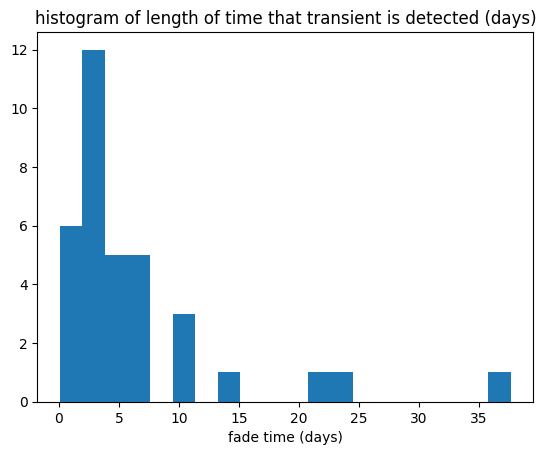

In [222]:
#generally these transients are meant to fade in a few hours

plt.hist(df_obs_arr['fade_time_days'],bins=20)
plt.title("histogram of length of time that transient is detected (days)")
plt.xlabel("fade time (days)")

In [236]:
def plot_observed_light_curve(row, log=True, snr=3):
    '''
    takes a row from an obs dataframe, for instance: detected_df.iloc[4]
    returns nothing
    plots the observed light curve with each filter
    as a random color
    and events with snr>3 are bigger (open circles)
    nondetections are small dots
    '''
    unique_filters = np.unique(row['filter'])
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_filters)))
    filter_to_color = dict(zip(unique_filters, colors))
    color_array = np.array([filter_to_color[f] for f in row['filter']])


    snr_obs_mask = row['snr_obs'] > snr  # change threshold here
    snr_to_marker = {False: '.', True: 'o'}

    # plt.figure(figsize=(10, 6))

    # Loop over each filter and SNR condition
    for snr_cond in [True, False]:
            mask = (snr_obs_mask == snr_cond)
            if np.any(mask):  # Only plot if there are matching points
                if log:
                    plt.scatter(
                        np.log10(row['mjd_obs'][mask]),
                        row['mag_obs'][mask],
                        c=color_array[mask],
                        marker=snr_to_marker[snr_cond]
                    )
                else:
                    plt.scatter(
                        row['mjd_obs'][mask],
                        row['mag_obs'][mask],
                        c=color_array[mask],
                        marker=snr_to_marker[snr_cond]
                    )

    if log:
        plt.xlim(np.log10(row['peak_mjd'] - 10), np.log10(row['peak_mjd'] + 100))
    else:
        plt.xlim(row['peak_mjd'] - 10, row['peak_mjd'] + 100)
    plt.gca().invert_yaxis()
    if log:
        plt.xlabel("log MJD")
    else:
        plt.xlabel("MJD")
    plt.ylabel("Apparent mag")
    plt.title("Light Curve as Observed")
    plt.legend(["Large means detected",
                "Each color is a filter"])
    plt.tight_layout()
    plt.ylim(40,16)
    # plt.xscale("log")
    plt.show()


In [237]:
detected_df = df_obs_arr[df_obs_arr['detected']==True]
print(len(detected_df))

20


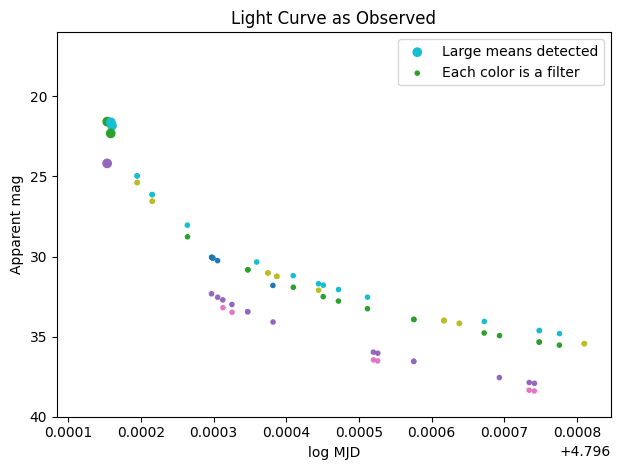

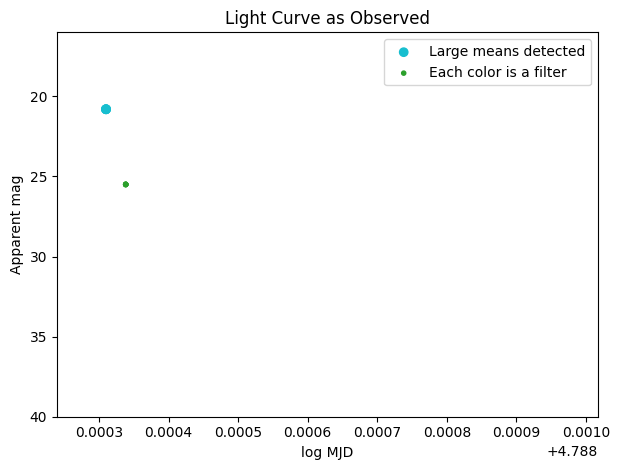

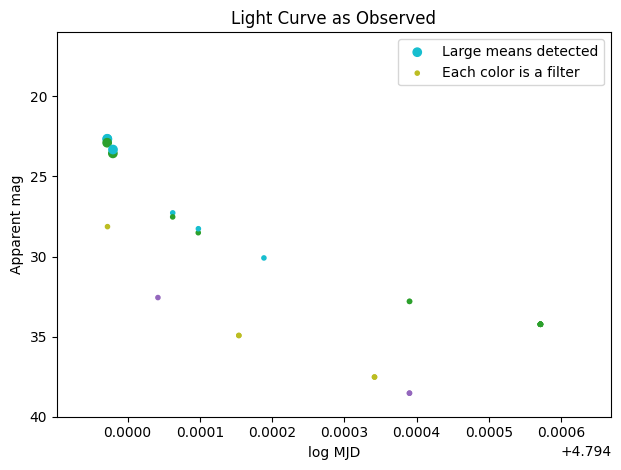

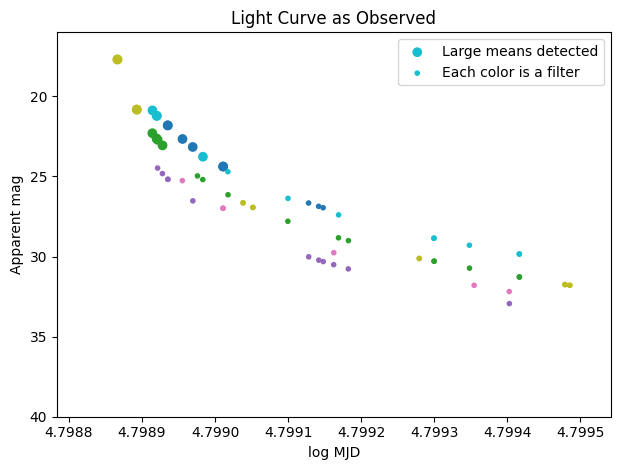

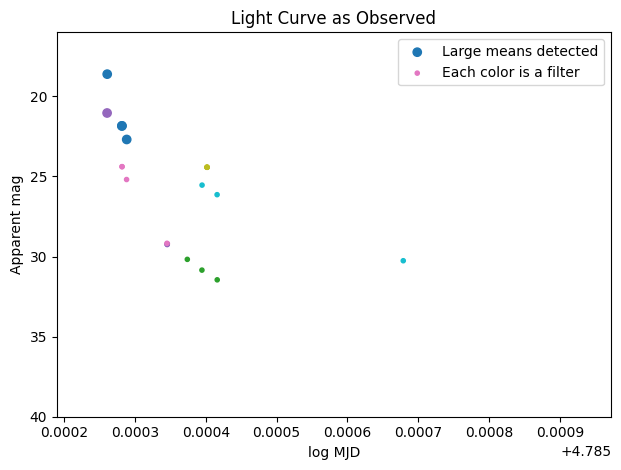

In [238]:
num_plotted=0
for i, row in detected_df.iterrows():
    plot_observed_light_curve(row,log=True)
    if num_plotted>3:
        break
    num_plotted+=1

In [227]:


rates = [estimate_fade_rate(shared_lc_model, i, "r", t1=1.0, t2=10.0) for i in range(len(shared_lc_model.data))]
plt.hist(rates, bins=30)
plt.xlabel("Fade Rate (mag/day)")
plt.ylabel("Number of Light Curves")
plt.title("Empirical Fade Rates from Synthetic GRB Light Curves")
plt.grid(True)
plt.show()

NameError: name 'estimate_fade_rate' is not defined

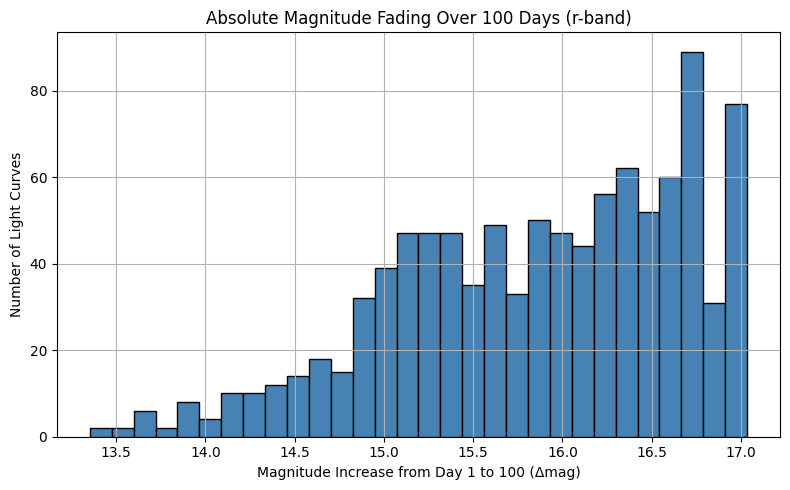

In [235]:
def compute_absolute_fade(lc_model, filtername="r", t1=1.0, t2=100.0):
    """
    Compute Δmag = m(t2) - m(t1) in a given filter for all GRB light curves.
    """
    deltas = []
    for i in range(len(lc_model.data)):
        mag_t1 = np.interp(t1, lc_model.data[i][filtername]['ph'],
                                 lc_model.data[i][filtername]['mag'])
        mag_t2 = np.interp(t2, lc_model.data[i][filtername]['ph'],
                                 lc_model.data[i][filtername]['mag'])
        deltas.append(mag_t2 - mag_t1)
    return np.array(deltas)

delta_mags = compute_absolute_fade(shared_lc_model, filtername='r')

plt.figure(figsize=(8, 5))
plt.hist(delta_mags, bins=30, color='steelblue', edgecolor='black')
plt.xlabel("Magnitude Increase from Day 1 to 100 (Δmag)")
plt.ylabel("Number of Light Curves")
plt.title("Absolute Magnitude Fading Over 100 Days (r-band)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [240]:

# Load the CSV (after fixing how arrays were saved, as discussed)
# df = pd.read_csv("GRBafterglows_output/ObsRecords_four_roll_v4.3.1_10yrs.csv")
new_df = pd.read_csv("GRBafterglows_fixedpop_detectonly/rd1em08/Metric_temp_four_roll_v4.3.1_10yrs/ObsRecords_four_roll_v4.3.1_10yrs.csv", converters={'filter': eval})

# Count how many are detected vs not
detected_counts = new_df['detected'].value_counts()

print("Detection Summary:")
print(detected_counts)

# Optionally print percentages
print("\nDetection Percentages:")
print(detected_counts / len(df) * 100)


Detection Summary:
detected
False    268
True      23
Name: count, dtype: int64

Detection Percentages:
detected
False    92.09622
True      7.90378
Name: count, dtype: float64


In [172]:
print(pd.DataFrame(obs_records).applymap(lambda x: len(x) if hasattr(x, '__len__') and not isinstance(x, str) else 'scalar').nunique()) #


mjd_obs           174
mag_obs           174
snr_obs           174
filter            174
first_det_mjd       1
last_det_mjd        1
rise_time_days      1
fade_time_days      1
sid                 1
file_indx           1
ra                  1
dec                 1
distance_Mpc        1
peak_mjd            1
peak_mag            1
ebv                 1
peak_time           1
detected            1
dtype: int64


/var/folders/tp/cclflcq51yqbq43tdzvfqh_c0000gn/T/ipykernel_87009/929288799.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(pd.DataFrame(obs_records).applymap(lambda x: len(x) if hasattr(x, '__len__') and not isinstance(x, str) else 'scalar').nunique()) #
